In [1]:
# Import libraries
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.cross_decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util_arch as util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from sklearn.exceptions import ConvergenceWarning
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Maybe y should also be scaled? 
# Perhaps a transform would be more effective, or scaling implemented with consistent cross-validation
# Different scaling methods? 
#     This seems most important for noise-sensitive models like LARS. All other use StandardScaler()
# Transformers?
# Model-specific scaling methods?
#     Yes, see above
# Common cross-validation function ✓
#     Use built-in functions wherever possible and `utils.gridsearch_pickparams()` elsewhere
# Quantile loss
# RANSAC
# Data augmentation? (Mixup)
# Data generation? (SMOGN)
# Combine CHH dataset ✓
# Implement CV and test ✓
# Print selected features ✓
# Make magnitude templates
# Sample weights ✓
# Look at segmentations by error ✓ (Appears to have most difference in red nucleus, which includes surrounding (white?) matter for underperforming cases)
# Extract features from current (1:6) eroded ROIs
# Extract features from all ROIs
# Plot segmentation variance against error for each case across all ROIs ✓
# Why does excluding the subthalamic nucleus increase the correlation (r=0.5 -> r=0.6)?
# Best performance with all ROIs: cvn=6, k=1800
# Best performance with ROIs 0:4, excluding STN: cvn=6, k=1800
# Should the pre-operative UPDRS be appended once or to each ROI? ✓
# Plot histogram of features for successful and unsuccessful predictions

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)

ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
print(R_all_c)
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    K = np.append(K,['pre_updrs'],0)
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix
[[['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra' ... 'Left substantia nigra'
   'Left substantia nigra' 'Left substantia nigra']
  ['Right Substantia nigra' 'Right Substantia nigra'
   'Right Substantia nigra' ... 'Right Substantia nigra'
   'Right Substantia nigra' 'Right Substantia nigra']]

 [['Left red nucleus' 'Left red nucleus' 'Left red nucleus' ...
   'Left red nucleus' 'Left red nucleus' 'Left red nucleus']
  ['Right red nucleus' 'Right red nucleus' 'Right red nucleus' ...
   'Right red nucleus' 'Right red nucleus' 'Right red nucleus']
  ['Left substantia nigra' 'Left substantia nigra'
   'Left substantia nigra

In [5]:
# # Augment with CHH data
# X0_gt = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
# df = pd.read_csv('/home/ali/RadDBS-QSM/data/xlxs/updrs_iii_chh.csv')
# # Patient IDs
# subject_id = np.asarray(df[df.columns[0]])[1:]
# # Data
# s_directory = open('/home/ali/RadDBS-QSM/data/roi/roi_list','r').read().splitlines()
# # Load
# with open('/home/ali/RadDBS-QSM/data/pickles/segs_chh', "rb") as fp:  
#     segs = pickle.load(fp)
#     n_cases = len(segs)
# with open('/home/ali/RadDBS-QSM/data/pickles/qsms_chh', "rb") as fp:  
#     qsms = pickle.load(fp)
# with open('/home/ali/RadDBS-QSM/data/phi/chh/Phi_mcl_gt_roi_chh', "rb") as fp:  
#         Phi_gt = pickle.load(fp)
# L = int(len(X0_gt)/n_cases)
# n_features = int(L/n_rois)
# # Only extract ROI if it is present in all cases
# seg_labels_all = segs[0]
# case_number = np.zeros_like(np.asarray(s_directory))
# for i in range(n_cases):
#     case_number[i] = float(s_directory[i][-2:])
# subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
# for i in range(n_cases):
#     #try:
#         print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
#     #except:
#         print('Case',subject_id[i],'quarantined')
# pre_updrs_iii_off =  np.asarray(df[df.columns[3]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])                                
# pre_updrs_iii_on =  np.asarray(df[df.columns[4]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])
# post_updrs_iii_off =  np.asarray(df[df.columns[6]][np.hstack((False,np.in1d(subject_id,subject_id_corr)))])

# per_change = np.hstack((per_change,(np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))))
# pre_updrs_off = np.hstack((pre_updrs_off, pre_updrs_iii_off))
# X0_gt = X0_gt.reshape((n_cases,n_rois,n_features))[:,0:4,:]
# X_all_c = np.vstack((X_all_c,X0_gt[:,:,:-1]))
# lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
# pre_imp = np.hstack((pre_imp,lct_change))
# subject_id_corr=subject_id_corr+100
# subsc = np.hstack((subsc,subject_id_corr))

In [6]:
# nii_dir = '/home/ali/RadDBS-QSM/data/nii'
# qsms = []
# segs = []
# for j in np.arange(len(subsc)):
#     if subsc[j] < 10:
#         qsms.append(nii_dir+'/qsm/QSM_e10_imaginary_0'+str(int(subsc[j]))+'.nii.gz')
#         segs.append(nii_dir+'/seg/labels_2iMag0'+str(int(subsc[j]))+'.nii.gz')
#     else:
#         qsms.append(nii_dir+'/qsm/QSM_e10_imaginary_'+str(int(subsc[j]))+'.nii.gz')
#         segs.append(nii_dir+'/seg/labels_2iMag'+str(int(subsc[j]))+'.nii.gz')

# V, M, subs_err = util.roi_var(qsms,segs,[1,2,3,4,5,6])
# np.save('V.npy',V)
# np.save('U.npy',M)
# V = np.load('V.npy')
# M = np.load('U.npy')

In [7]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [8]:
# chi = []
# for j in np.arange(len(qsms)):
#     data = nib.load(qsms[j]).get_fdata()
#     if int(qsms[j][-9:-7]) == int(segs[j][-9:-7]):
#         try:
#             mask = nib.load(segs[j]).get_fdata()
#             img = util.pad_to((data[:,:,~(mask==0).all((0,1))])[192:320,192:320,:],128,128,108)
#             chi.append(img)
#             print('Loading',qsms[j],'of shape',str(img.shape))
#         except:
#             print('Skipping',qsms[j])
#             subsc = np.delete(subsc,j)
#             per_change = np.delete(per_change,j)
#             X_all_c = np.delete(X_all_c,j,axis=0)
#             pre_updrs_off = np.delete(pre_updrs_off,j)

In [20]:
Js = []
for j in np.arange(len(subsc)):
    test_id = subsc[j]
    test_index = subsc == test_id
    train_index = subsc != test_id
    X_train = X_all_c[train_index,:,:]
    X_test = X_all_c[test_index,:,:]
    y_train = per_change[train_index]
    y_test = per_change[test_index]

    idy = y_train[y_train<=0.3]
    
    # Cross validation
    cvn = 6
    X0_ss0,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                X_train,train_index,X_test,test_index,pre_updrs_off,False,False,False)
    lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,normalize=False,eps=0.1,n_jobs=1)
    
    with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
      # Feature selection
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      sel = skf.SelectKBest(skf.r_regression,k=2925)
      X0_sst = sel.fit_transform(X0_ss0,y_train)
      X_test_sst = sel.transform(X_test_ss0)
      gel = skf.RFECV(lasso,verbose=1,cv=cvn,step=1000,n_jobs=1)
      X0_ss = gel.fit_transform(X0_sst,y_train)
      X_test_ss = gel.transform(X_test_sst)
     #Ks.append(sel.transform(K.reshape(1, -1)))
      dx, y_n = cKDTree(X0_ss).query(X_test_ss, k=1)


    # LASSO
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning)
      lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=1,normalize=False,eps=0.1)
      est_ls = lasso.fit(X0_ss,y_train)
    # Reconstruct nearest neighbor
    r[j] = est_ls.predict(X0_ss[y_n,:])
    err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
    rerror[j] = np.abs(r[j]-y_train[y_n])
    #s.append(est_ls.score(X0_ss,y_train))
    results_ls[j] = est_ls.predict(X_test_ss)
    # If reconstruction error is too high, use nearest neighbor
    if rerror[j] > 0.1:
      results_ls[j] = y_train[y_n]

    else:
      # LASSO
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=cvn,n_jobs=1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_ss,y_train)
      # Reconstruct nearest neighbor
      r[j] = est_ls.predict(X0_ss[y_n,:])
      err_var[j] = np.mean(abs(est_ls.predict(X0_ss)-y_train))
      rerror[j] = np.abs(r[j]-y_train[y_n])
      #s.append(est_ls.score(X0_ss,y_train))
      results_ls[j] = est_ls.predict(X_test_ss)
        #results_ls[j] = r[j]
      w.append(est_ls.coef_)
    print('Lasso predicts',str(np.round(results_ls[j],2)),
              'for case with',str(np.round(per_change[j],2)),
              'with regularization',str(est_ls.alpha_),
              'with reconstruction error',str(np.round(rerror[j],9)),
              'maximum error',str(np.round(err_var[j],9)),
              'and neighbor',str(np.round(y_train[y_n],2).item()))
    gerror[j] = (abs(results_ls[j]-y_test))
        
    if gerror[j] > 0.15:
          pcases.append(test_id)
          pscores.append(s)
  


Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting estimator with 925 features.
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Lasso predicts 0.44 for case with 0.48 with regularization 0.0003465307963174154 with reconstruction error 0.001017516 maximum error 0.001389737 and neighbor 0.43
Fitting estimator with 2925 features.
Fitting estimator with 1925 features.
Fitting

Text(0.5, 1.0, 'Error estimation')

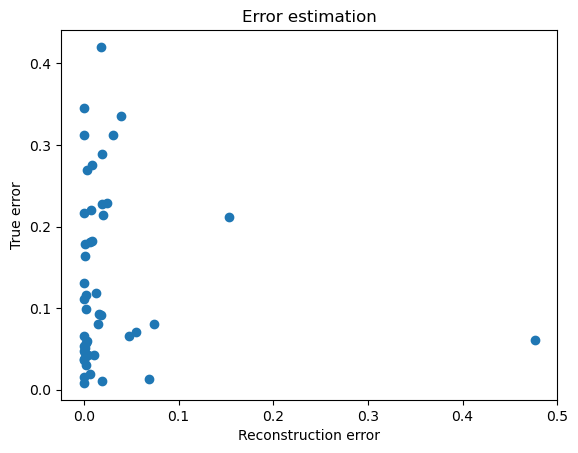

In [21]:
plt.scatter(rerror,gerror)
plt.xlabel('Reconstruction error')
plt.ylabel('True error')
plt.title('Error estimation')

In [22]:
# fig,ax = plt.subplots()
# df = pd.DataFrame({'Feature':(Kstg[wg != 0]).tolist()})
# hist = df['Feature'].value_counts()#.plot(kind='bar',ax=ax)
# ax.plot(hist[hist>1])
#ax.get_legend().remove()
# plt.ylabel('Frequency')
# plt.xticks(rotation=90)
# plt.title('Case ' + str(int(j)) + ', subject ' + str(subsc[j]) + ' with error ' + str(np.round(gerror[j],2)))
# plt.rcParams["figure.figsize"] = (20,5)
# plt.style.use('dark_background')
# plt.show()

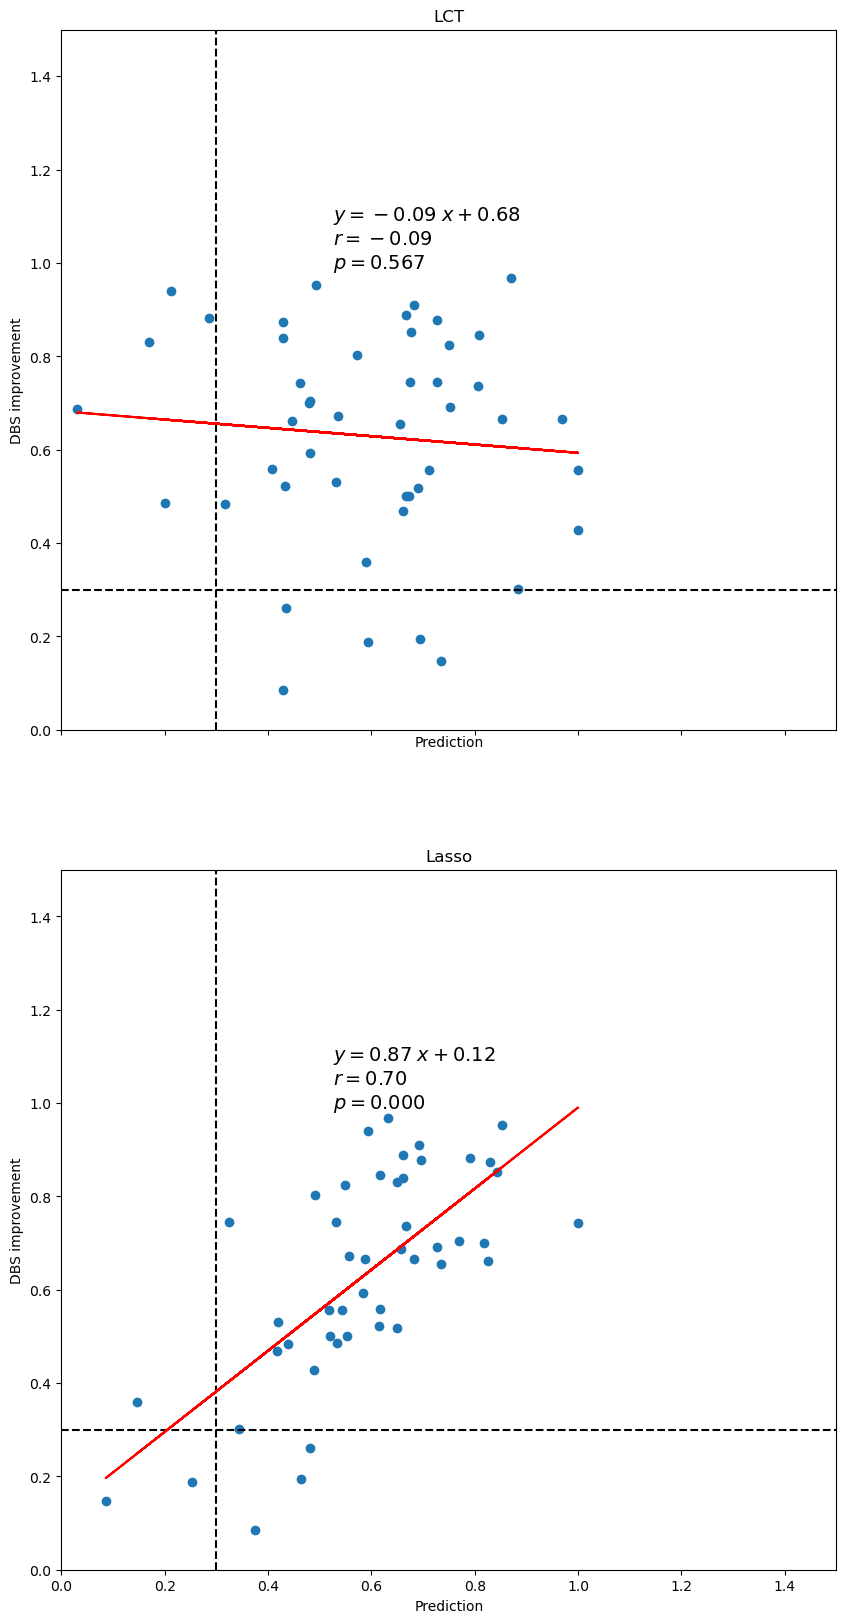

In [23]:
results_ls[results_ls>1] = 1
util.eval_prediction(np.vstack((pre_imp,
                               results_ls,
                               )),
                               per_change,
                               ['LCT',
                                'Lasso',
                                ],(20,10))
plt.ylim([0,1.5])
plt.xlim([0,1.5])
plt.style.use('default')

In [24]:
# fig,ax = plt.subplots(3,2,sharex=True,sharey=True)
# plt.style.use('dark_background')
# plt.rcParams["figure.figsize"] = (10,10)
# ax[0,0].scatter(V[:,0]/1000,gerror)
# ax[0,0].set_title('Right red nucleus')
# ax[0,1].scatter(V[:,1]/1000,gerror)
# ax[0,1].set_title('Left red nucleus')
# ax[1,0].scatter(V[:,2]/1000,gerror)
# ax[1,0].set_title('Right substantia nigra')
# ax[1,1].scatter(V[:,3]/1000,gerror)
# ax[1,1].set_title('Left substantia nigra')
# ax[2,0].scatter(V[:,4]/1000,gerror)
# ax[2,0].set_title('Right subthalamic nuclei')
# ax[2,1].scatter(V[:,5]/1000,gerror)
# ax[2,1].set_title('Left subthalamic nuclei')
# plt.setp(ax[-1, :], xlabel='Variance');
# plt.setp(ax[:, 0], ylabel='Error');